# Reasoning without Observation


In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = "plan-and-execute"
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
from typing import List, TypedDict


class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

## Planner


In [3]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: what is the hometown of the 2024 australian open winner?
Plan: Use Google to search for the 2024 Australian Open winner.
#E1 = Google[2024 Australian Open winner]
Plan: Retrieve the name of the 2024 Australian Open winner from the search results.
#E2 = LLM[What is the name of the 2024 Australian Open winner, given #E1]
Plan: Use Google to search for the hometown of the 2024 Australian Open winner.
#E3 = Google[hometown of 2024 Australian Open winner, given #E2]
Plan: Retrieve the hometown of the 2024 Australian Open winner from the search results.
#E4 = LLM[What is the hometown of the 2024 Australian Open winner, given #E3]

Describe your plans with rich details. Each Plan should be followed by only one #E.
Task: {task}"""

In [4]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-2024-08-06", temperature=0)

task = "Where does the lead actor of 2023's highest-grossing film live?"

result = model.invoke(prompt.format(task=task))
print(result.content)

Plan: Use Google to search for the highest-grossing film of 2023.
#E1 = Google[highest-grossing film of 2023]

Plan: Retrieve the name of the highest-grossing film of 2023 from the search results.
#E2 = LLM[What is the name of the highest-grossing film of 2023, given #E1]

Plan: Use Google to search for the lead actor of the highest-grossing film of 2023.
#E3 = Google[lead actor of #E2]

Plan: Retrieve the name of the lead actor from the search results.
#E4 = LLM[What is the name of the lead actor of #E2, given #E3]

Plan: Use Google to search for the current residence of the lead actor identified in the previous step.
#E5 = Google[current residence of #E4]

Plan: Retrieve the current residence of the lead actor from the search results.
#E6 = LLM[Where does #E4 currently live, given #E5]


In [5]:
import re

regex_pattern = r"Plan\:\s*(.*?)\s*(#E\d+)\s*=\s*(\w+)\[(.*?)\]"
matches = re.findall(regex_pattern, result.content)
print(matches)

[('Use Google to search for the highest-grossing film of 2023.', '#E1', 'Google', 'highest-grossing film of 2023'), ('Retrieve the name of the highest-grossing film of 2023 from the search results.', '#E2', 'LLM', 'What is the name of the highest-grossing film of 2023, given #E1'), ('Use Google to search for the lead actor of the highest-grossing film of 2023.', '#E3', 'Google', 'lead actor of #E2'), ('Retrieve the name of the lead actor from the search results.', '#E4', 'LLM', 'What is the name of the lead actor of #E2, given #E3'), ('Use Google to search for the current residence of the lead actor identified in the previous step.', '#E5', 'Google', 'current residence of #E4'), ('Retrieve the current residence of the lead actor from the search results.', '#E6', 'LLM', 'Where does #E4 currently live, given #E5')]


In [6]:
import re

from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form E#... = ...[...]

regex_pattern = r"Plan\:\s*(.*?)\s*(#E\d+)\s*=\s*(\w+)\[(.*?)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | model


def get_plan(state: ReWOO):
    task = state["task"]
    result = planner.invoke({"task": task})
    # Find all matches in the sample text
    matches = re.findall(regex_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}

## Executor


In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults()


def _get_current_task(state: ReWOO):
    if state["results"] is None:
        # first task
        return 1
    if len(state["results"]) == len(state["steps"]):
        # last task
        return None
    else:
        # next task
        return len(state["results"]) + 1


def tool_execution(state: ReWOO):
    """Worker node that executes the tools of a given plan."""
    _step = _get_current_task(state)
    print(f"Executing step {_step}")
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    print(f"Step {step_name}")
    print(f"Tool: {tool}")
    print(f"Tool input: {tool_input}")
    _results = state["results"] or {}
    print(f"Results: {_results}")
    for k, v in _results.items():
        print(f"tool_input: {tool_input}")
        print(f"Replacing {k} with {v}")
        tool_input = tool_input.replace(k, v)
    if tool == "Google":
        result = search.invoke(tool_input)
    elif tool == "LLM":
        prompt = "Find the answer of the question and extract the answer only with given information:"
        result = model.invoke(prompt + "\n" + tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    print(f"Results: {_results}")
    return {"results": _results}

## Solver


In [8]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""


def solve(state: ReWOO):
    plan = ""
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = state["results"] or {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = model.invoke(prompt)
    return {"result": result.content}

## Graph


In [9]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"


from langgraph.graph import END, StateGraph

graph = StateGraph(ReWOO)

graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)

graph.set_entry_point("plan")
graph.add_edge("plan", "tool")
graph.set_finish_point("solve")
graph.add_conditional_edges("tool", _route)


app = graph.compile()

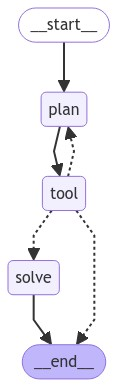

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [11]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'plan_string': 'Plan: Use Google to search for the highest-grossing film of 2023.\n#E1 = Google[highest-grossing film of 2023]\n\nPlan: Retrieve the name of the highest-grossing film of 2023 from the search results.\n#E2 = LLM[What is the name of the highest-grossing film of 2023, given #E1]\n\nPlan: Use Google to search for the lead actor of the highest-grossing film of 2023.\n#E3 = Google[lead actor of #E2]\n\nPlan: Retrieve the name of the lead actor from the search results.\n#E4 = LLM[What is the name of the lead actor of the highest-grossing film of 2023, given #E3]\n\nPlan: Use Google to search for the current residence of the lead actor.\n#E5 = Google[current residence of #E4]\n\nPlan: Retrieve the current residence of the lead actor from the search results.\n#E6 = LLM[Where does the lead actor of the highest-grossing film of 2023 live, given #E5]', 'steps': [('Use Google to search for the highest-grossing film of 2023.', '#E1', 'Google', 'highest-grossing film of 2023

In [12]:
# Print out the final result
print(s["solve"]["result"])

I'm unable to provide the answer to your question based on the given information.


In [13]:
task = "what is the hometown of the 2024 australian open winner"
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'plan_string': "Plan: Use Google to search for the 2024 Australian Open winner. This will provide the most up-to-date information on who won the tournament.\n#E1 = Google[2024 Australian Open winner]\n\nPlan: Retrieve the name of the 2024 Australian Open winner from the search results obtained in #E1. This step is crucial to identify the individual whose hometown we need to find.\n#E2 = LLM[What is the name of the 2024 Australian Open winner, given #E1]\n\nPlan: Use Google to search for the hometown of the 2024 Australian Open winner using the name obtained in #E2. This will help us find specific information about the winner's place of origin.\n#E3 = Google[hometown of 2024 Australian Open winner, given #E2]\n\nPlan: Retrieve the hometown of the 2024 Australian Open winner from the search results obtained in #E3. This will provide the final answer to the task.\n#E4 = LLM[What is the hometown of the 2024 Australian Open winner, given #E3]", 'steps': [('Use Google to search for